<br>
<u>Notebook Eight</u> | 
<a href=https://leone.gdn/DLL target=_blank>Report</a> | 
<a href=https://github.com/andrealeone/DLL>Repository</a>
<br><br>
<b>Task 1: The Super-Model</b><br><br>
Andrea Leone, Alessandro E. Piotti<br>
Deep Learning Lab — University of Trento<br>
December 2021
<hr><br><br>

In [1]:
import project 
import networks

import os
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import random
import pickle
import collections

import torch
import torch.nn          as nn
import torch.optim       as optim
import torchvision
import networks

from tqdm.notebook   import tqdm

project.notebook()

In [2]:
images, annotations = project.load_resources() 

<hr><br><br>

## Super-model

<br><br>Load the data

In [3]:
dictionary = dict() 
split_val  = 640                # 751-640=151
irm        = torchvision.io.ImageReadMode.RGB
device     = torch.device('cpu') 

for image_file in tqdm(images):
    
    image_id  = image_file.split('/')[-1].split('_')[0]
    
    labels    = annotations.loc[int( image_id )].to_numpy() - 1 
    tensor    = torchvision.io.read_image( image_file, irm ).float()

    channels, height, width = tensor.shape
    tensor    = tensor.reshape(1, channels, height, width).to(device)
    
    if image_id not in dictionary:
        dictionary[image_id] = list()
        dictionary[image_id].append([tensor, labels])
    else:
        dictionary[image_id].append([tensor, labels])
    
data = list(dictionary.items())
random.Random(3).shuffle(data)

train_set, test_set = project.split_dataset(data,split_val)

  0%|          | 0/12989 [00:00<?, ?it/s]

<br><br>Load the models

In [4]:
models = { 

    'gender':   ( './models/gender_resnet50.v1.x7.net',   networks.ResNet50() ), # 6144
    'hair':     ( './models/hair_resnet50.v3.x4.net',     networks.ResNet50() ), #  512
    'hat':      ( './models/hat_resnet50.v2.x6.net',      networks.ResNet50() ), #  512
    'clothes':  ( './models/clothes_resnet50.v1.x6.net',  networks.ResNet50() ), # 2048
    'up':       ( './models/up_resnet50.v1.x5.net',       networks.ResNet50() ), # 2048
    'down':     ( './models/down_resnet50.v1.x6.net',     networks.ResNet50() ), # 2048
    'backpack': ( './models/backpack_resnet50.v1.x3.net', networks.ResNet50() ), # 2048
    'bag':      ( './models/bag_resnet50.v1.x5.net',      networks.ResNet50() ), # 2048
    'handbag':  ( './models/handbag_resnet50.v1.x5.net',  networks.ResNet50() ), # 2048

}

for k, lib in models.items(): 

    weights_dir, model = models[k]
    model.load_state_dict( torch.load( weights_dir, map_location=device ) )

    models[k] = model

In [5]:
models_ensemble = { 

    'age': {
        'ensemble': ('./models/age_ensemble.v1_0.x20.net', networks.lib()['age']),
        'models_src': [
            ( './models/age_3cnv_5fc_f0.v4.x10.net',           networks.CNN(6144) ),
            ( './models/age_3cnv_5fc_f1.v4.x10.net',           networks.CNN(6144) ),
            ( './models/age_3cnv_5fc_f2.v4.x10.net',           networks.CNN(6144) ),
            ( './models/age_3cnv_5fc_f3.v4.x10.net',           networks.CNN(6144) )
        ]
    },

    'colors_up': {
        'ensemble': ('./models/colors_up_ensemble.v1_2.x10.net', networks.lib()['colors_up']),
        'models_src': [
            ( './models/colors_up_resnet50_f0.v3_2.x22.net',   networks.ResNet50() ),
            ( './models/colors_up_resnet50_f1.v3_2.x8.net',    networks.ResNet50() ),
            ( './models/colors_up_resnet50_f2.v3_2.x3.net',    networks.ResNet50() ),
            ( './models/colors_up_resnet50_f3.v3_2.x3.net',    networks.ResNet50() ),
            ( './models/colors_up_resnet50_f4.v3_2.x5.net',    networks.ResNet50() ),
            ( './models/colors_up_resnet50_f5.v3_2.x4.net',    networks.ResNet50() ),
            ( './models/colors_up_resnet50_f6.v3_2.x12.net',   networks.ResNet50() ),
            ( './models/colors_up_resnet50_f7.v3_2.x8.net',    networks.ResNet50() ),
            ( './models/colors_up_resnet50_f8.v3_2.x4.net',    networks.ResNet50() )
        ]
    },

    'colors_down': {
        'ensemble': ('./models/colors_down_ensemble.v1_2.x10.net', networks.lib()['colors_down']),
        'models_src': [
            ( './models/colors_down_resnet50_f0.v3_2.x5.net',  networks.ResNet50() ),
            ( './models/colors_down_resnet50_f1.v3_2.x6.net',  networks.ResNet50() ),
            ( './models/colors_down_resnet50_f2.v3_2.x9.net',  networks.ResNet50() ),
            ( './models/colors_down_resnet50_f3.v3_2.x15.net', networks.ResNet50() ),
            ( './models/colors_down_resnet50_f4.v3_2.x12.net', networks.ResNet50() ),
            ( './models/colors_down_resnet50_f5.v3_2.x11.net', networks.ResNet50() ),
            ( './models/colors_down_resnet50_f6.v3_2.x9.net',  networks.ResNet50() ),
            ( './models/colors_down_resnet50_f7.v3_2.x7.net',  networks.ResNet50() ),
            ( './models/colors_down_resnet50_f8.v3_2.x4.net',  networks.ResNet50() ),
            ( './models/colors_down_resnet50_f9.v3_2.x8.net',  networks.ResNet50() )
        ]
    }

}

for k, lib in models_ensemble.items(): 
    
    models[k]     = {}
    lib['models'] = []
    
    for weights_dir, model in lib['models_src']: 
        model.load_state_dict(
            torch.load( weights_dir, map_location=device )
        )
        lib['models'].append( model )
    del lib['models_src']
    
    weights_dir, model = lib['ensemble']
    model.load_state_dict(
        torch.load( weights_dir, map_location=device )
    )
    
    lib['ensemble'] = model
    models[k] = lib

<hr>

<br><br>Analyse the target

In [6]:
annotations.iloc[0].to_dict()

{'age': 2,
 'backpack': 1,
 'bag': 1,
 'handbag': 1,
 'clothes': 2,
 'down': 1,
 'up': 2,
 'hair': 1,
 'hat': 1,
 'gender': 1,
 'upblack': 1,
 'upwhite': 1,
 'upred': 1,
 'uppurple': 1,
 'upyellow': 2,
 'upgray': 1,
 'upblue': 1,
 'upgreen': 1,
 'downblack': 2,
 'downwhite': 1,
 'downpink': 1,
 'downpurple': 1,
 'downyellow': 1,
 'downgray': 1,
 'downblue': 1,
 'downgreen': 1,
 'downbrown': 1}

<br><br>Process the input for different sizes

In [7]:
x, y = train_set[0] 

In [8]:
def split_in_shapes(tensor): 
    
    results = []
    shapes  = [
        (0,128), (0,35), (20,80), (40,100), (60,120)
    ]
    
    for a,b in shapes:
        
        shape = [] 
        for c in tensor[0]:
            shape.append( c[a:b].numpy() ) 
        
        results.append( torch.tensor([shape]).float().to(device) ) 
    
    return results

<br><br>Test a model ensemble

In [9]:
np.array([ 
    model(x).detach().numpy()[0]
    for model in models['age']['models']
]) 

array([[-0.07793319,  0.31359875],
       [-0.47591186,  0.50973964],
       [ 0.00869999, -0.01950193],
       [-0.00923227, -0.37455988]], dtype=float32)

In [10]:
models['age']['ensemble']( 
    torch.tensor([ 
        model(x).detach().numpy()[0]
        for model in models['age']['models']
    ]).reshape(-1)
).detach().numpy() 

array([[-0.16983554,  2.4927192 ,  0.81516695, -0.16804755]],
      dtype=float32)

<br><br>Test a simple model

In [12]:
models['gender'](x).detach().numpy() 

array([[-2.1430619,  2.133177 ]], dtype=float32)

<br><br>Assemble all models into a single one

In [13]:
def model(_input, src=models): 
    
    vector      = list()
    tensor_mode = split_in_shapes(_input)

    def add_simple_model_result_to(vector, attribute, shape): 
    
        vector.extend([
            np.argmax(

                src[attribute](shape)
                    .detach().numpy()

            )
        ])
    
    def add_ensemble_model_result_to(vector, attribute, shape, pad=False): 
        
        ms = src[attribute]['models']
        i  = np.argmax(

            src[attribute]['ensemble'](
                torch.tensor([ 

                    model( shape ).detach().numpy()[0]
                    for model in ms

                ]).reshape(-1)
            ).detach().numpy()

        )
        
        if pad:
            array = np.zeros( len(ms) - 1, dtype=int )
            
            if i > 0:
                array[i - 1] = 1
            
            vector.extend(array)
        
        else:
            vector.extend([ i ])
    
    add_ensemble_model_result_to(vector,
        attribute='age', shape=tensor_mode[0]
    )
    
    attribute_refs = [
        ('backpack', 2), ('bag', 2), ('handbag', 3),
        ('clothes', 4), ('down', 4), ('up', 2),
        ('hair', 1), ('hat', 1), ('gender', 0)
    ]
    
    for attribute, s in attribute_refs:
        add_simple_model_result_to(vector,
            attribute, shape=tensor_mode[s]
        )
    
    add_ensemble_model_result_to(vector,
        attribute='colors_up', shape=tensor_mode[2], pad=True
    )
    
    add_ensemble_model_result_to(vector,
        attribute='colors_down', shape=tensor_mode[4], pad=True
    )
    
    return np.array(vector)

<br><br>Check the results

In [14]:
r = model(x) 

print(y) 
print(r) 

[1 1 0 0 1 0 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
[1 1 0 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0]


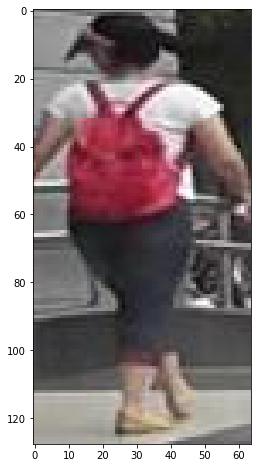

[['age         :' '1' '1']
 ['backpack    :' '1' '1']
 ['bag         :' '0' '0']
 ['handbag     :' '0' '0']
 ['clothes     :' '1' '1']
 ['down        :' '0' '0']
 ['up          :' '1' '1']
 ['hair        :' '1' '1']
 ['hat         :' '1' '0']
 ['gender      :' '1' '1']
 ['upblack     :' '0' '0']
 ['upwhite     :' '1' '0']
 ['upred       :' '0' '1']
 ['uppurple    :' '0' '0']
 ['upyellow    :' '0' '0']
 ['upgray      :' '0' '0']
 ['upblue      :' '0' '0']
 ['upgreen     :' '0' '0']
 ['downblack   :' '0' '0']
 ['downwhite   :' '0' '0']
 ['downpink    :' '0' '0']
 ['downpurple  :' '0' '0']
 ['downyellow  :' '0' '0']
 ['downgray    :' '0' '0']
 ['downblue    :' '1' '1']
 ['downgreen   :' '0' '0']
 ['downbrown   :' '0' '0']]


In [15]:
project.compare_image_attributes( 
    image=x, r1=y, r2=r,
    labels=annotations.columns
)

<br><br>Export the super-model

In [16]:
v  = '2'                        # archive version 

with open('./data/image_dict.train.v{}.pkl'.format(v), 'wb') as file: 
    pickle.dump(dictionary, file)

with open('./data/models.v{}.pkl'.format(v), 'wb') as file: 
    pickle.dump(models, file)

<br><br>